
# Libraries

In [2]:
# Basic
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Model
import keras
from keras import layers, Input, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from sklearn.model_selection import train_test_split

# Google Drive
from google.colab import drive

# Read .mat files
from scipy.io import loadmat

# Save model
import pickle


# Dataset

In [3]:
# Access to Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load thermal images
mat = loadmat('/content/drive/MyDrive/UFU/TCC/Codigo/Dados_Termograficos/IRT_Data/COMP412-6_Front_Flash-000136.mat')

The only data that matters right now is the temperature matrix.

In [5]:
data = mat['temperature']

In [6]:
# Check dataset characteristics

print('Type: ', type(data))             # type of
print('Dtype: ',data.dtype)
print('Number of dims: ',data.ndim)     # dimension of an image
print('Img shape: ',data.shape)         # shape of an image
print(data[20, 20])                     # pixel values

Type:  <class 'numpy.ndarray'>
Dtype:  float32
Number of dims:  3
Img shape:  (416, 421, 1385)
[25.799725 25.785278 25.828602 ... 26.840857 26.86901  26.840857]


We have 1385 thermal images. The shape of them is 416x421. First we transpose the matrix (416,421,1385) so we can split it in the train and test sets, the we reshape so the computational cost is lowered.

In [7]:
# Transpose matrix

data = np.transpose(data)

In [8]:
# Reshape matrix

input_shape = (128,128,1)

data = [cv2.resize(image, (input_shape[0], input_shape[1]), interpolation = cv2.INTER_CUBIC) for image in data]

Data Normalization (Min Max normalization)


In [9]:
data = [(image - np.min(image)) / (np.max(image) - np.min(image)) for image in data]

Transform data from list to ndarray from numpy library. This step is important because Keras
uses this kind of variable in the machine learning algorithms.

In [10]:
data = np.array(data, dtype = np.float32)

data.shape

(1385, 128, 128)

Separation in train and test subsets, which will be divided in:


*   Train, 80%
*   Test, 20%



In [11]:
# Train test split

x_train, x_test = train_test_split(data, test_size=0.2, random_state=0)

Add Gaussian noise to the images

In [12]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=.1, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=.1, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Images

Comparison between original and noisy images.

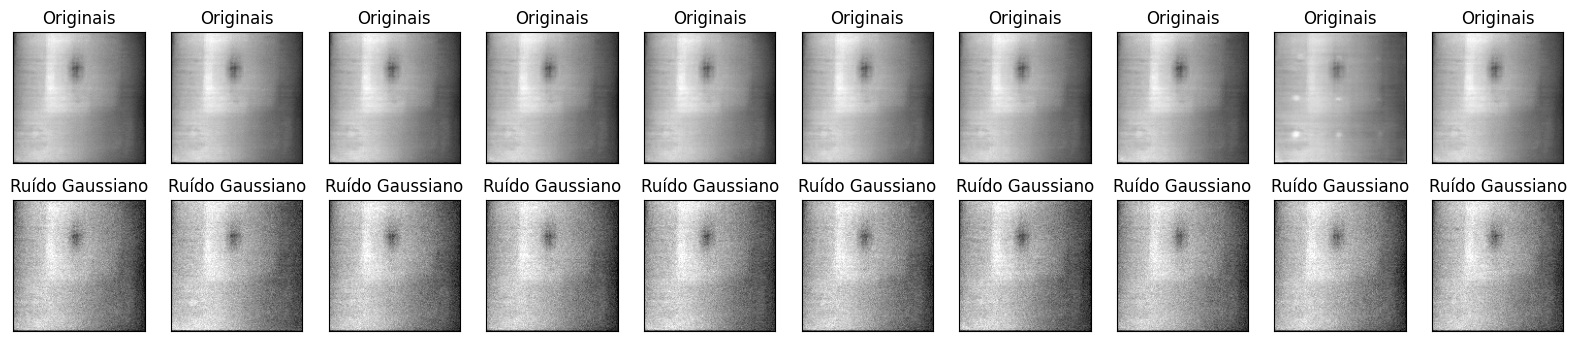

In [13]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.title('Originais')
    plt.imshow(x_test[i+50])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.title('Ruído Gaussiano')
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional (CNN) Autoencoder

In [14]:
input_img = keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

CNN Compilation using Adam optimizer and binary crossentropy as the loss function.

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', 'mean_squared_error', 'mae'])

Training step of the CNN. The data will be tested with 500 epochs and batches of size 128, which will be selected randomly.

In [16]:
history = autoencoder.fit(x_train_noisy,
                          x_train,
                          epochs=500,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

Epoch 1/500
9/9 [==============================] - 13s 124ms/step - loss: 0.6615 - accuracy: 6.1035e-05 - mean_squared_error: 0.0316 - mae: 0.1476 - val_loss: 0.6511 - val_accuracy: 6.1035e-05 - val_mean_squared_error: 0.0267 - val_mae: 0.1266
Epoch 2/500
9/9 [==============================] - 0s 33ms/step - loss: 0.6449 - accuracy: 6.1035e-05 - mean_squared_error: 0.0238 - mae: 0.1246 - val_loss: 0.6402 - val_accuracy: 6.1035e-05 - val_mean_squared_error: 0.0212 - val_mae: 0.1158
Epoch 3/500
9/9 [==============================] - 0s 33ms/step - loss: 0.6323 - accuracy: 8.5879e-05 - mean_squared_error: 0.0179 - mae: 0.1066 - val_loss: 0.6175 - val_accuracy: 1.2185e-04 - val_mean_squared_error: 0.0105 - val_mae: 0.0802
Epoch 4/500
9/9 [==============================] - 0s 33ms/step - loss: 0.6054 - accuracy: 1.2202e-04 - mean_squared_error: 0.0056 - mae: 0.0530 - val_loss: 0.6017 - val_accuracy: 1.2207e-04 - val_mean_squared_error: 0.0035 - val_mae: 0.0435
Epoch 5/500
9/9 [=============

# Results

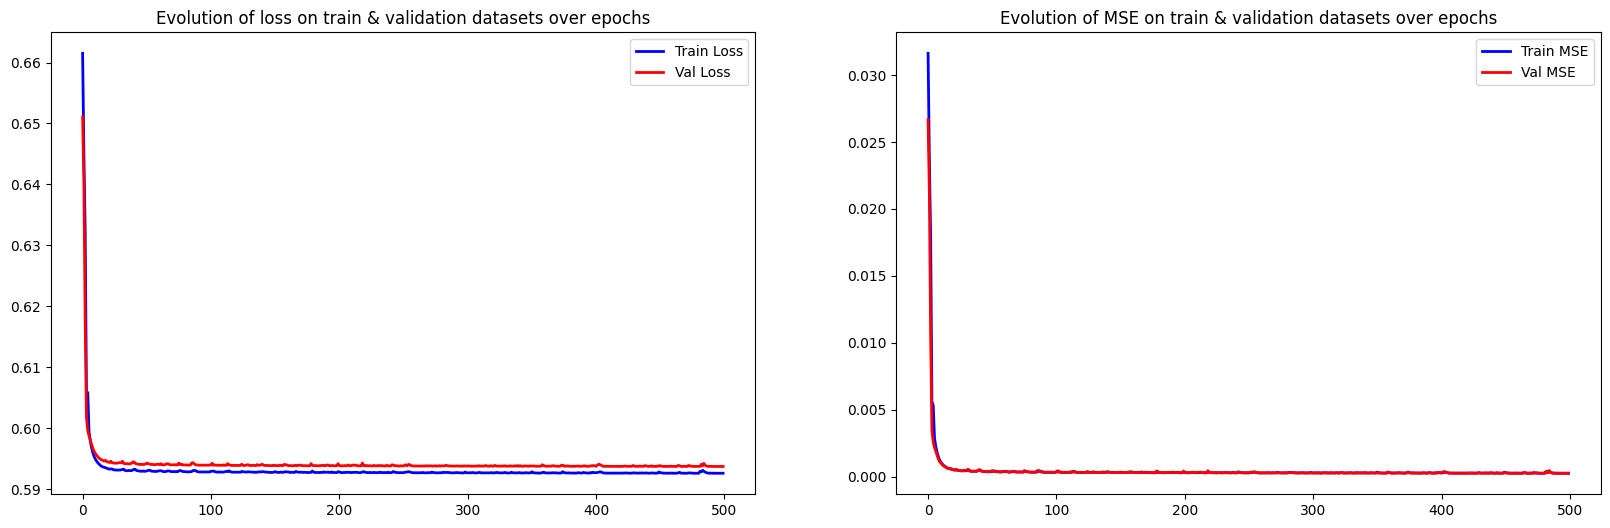

In [17]:
# Check how loss (binary crossentropy) and mean absolute error behaved

epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']
epoch_mse = history.history['mean_squared_error']
epoch_mse_val = history.history['val_mean_squared_error']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_mse_val)), epoch_mse_val, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [18]:
decoded_imgs = autoencoder.predict(x_test_noisy)

9/9 [==============================] - 0s 4ms/step


Comparison between original and reconstructed (recovered) images

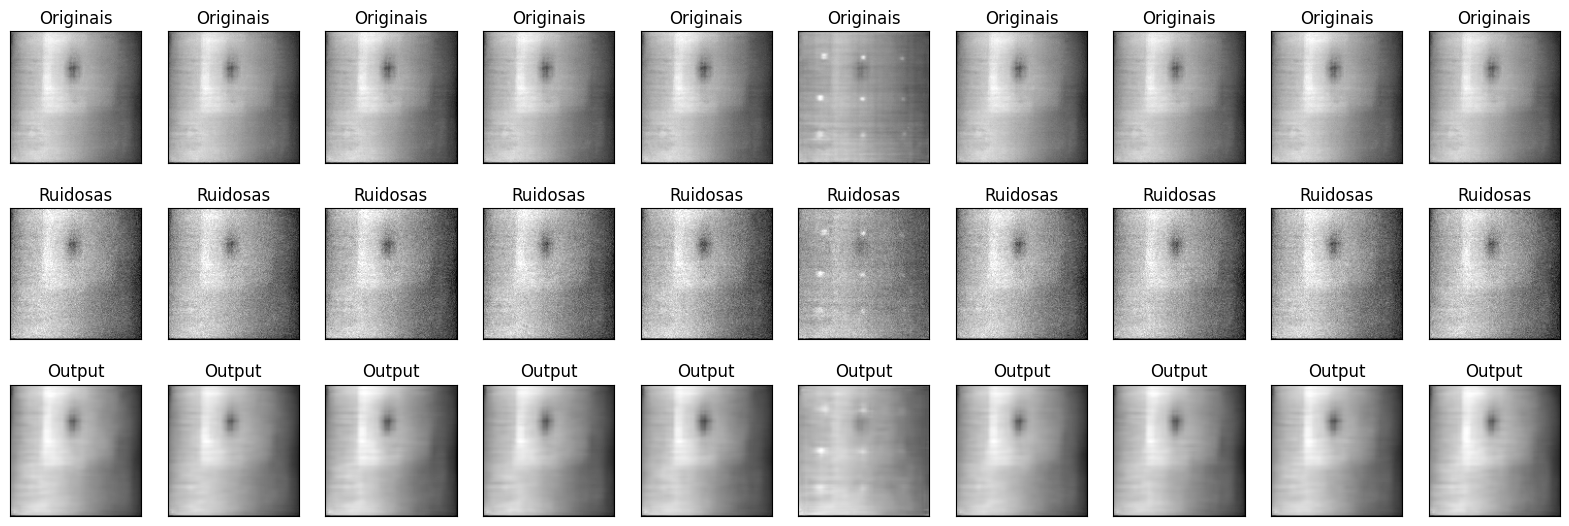

In [19]:
n = 10
j = 170

rows = 3
columns = 10

plt.figure(figsize=(20, 6.5))
for i in range(1, n + 1):
    ax = plt.subplot(rows, columns, i)
    plt.title('Originais')
    plt.imshow(x_test[i+j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(rows, columns, i + n)
    plt.title('Ruidosas')
    plt.imshow(x_test_noisy[i+j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(rows, columns, i + 2*n)
    plt.title('Output')
    plt.imshow(decoded_imgs[i+j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()